# Analysis of HEMCO Emissions

In [1]:
# calculate anthropogenic emissions of relevant compounds (SO2, SO4, NO, BCPI, BCPO, OCPI, OCPO, DST1, and NH3)
# over the UK for the 3 different scenarios.

# Load frequently used packages for data analysis
import os
import glob
import numpy  as np
import pandas 
import xarray as xr

# Load frequently used packages for data visualisations
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-white')


import geopandas as gpd
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
os.chdir('D:\Jupyter code')

from gamap_colormap import WhGrYlRd

In [3]:
# get all HEMCO outputs
os.chdir('D:/Jupyter code/mtf_uk_nest_hemco')
HEMCO_files = sorted(glob.glob("HEMCO*.nc"))
# display(HEMCO_files)

# read all HEMCO files
HEMCO_data = [xr.open_dataset(file) for file in HEMCO_files]

# check an example
display("an example of HEMCO full data:",HEMCO_data[1])

# check the data field for total NO emissions
# this means that for all area in a certain grid
# the emission rate is the same at "xx kg/m2/s"
# display(HEMCO_data[0]['EmisNO_Total'])

# extract the grid box surface area values (unit: m^2) 
# the area is fixed for each grid, so we only need to read it once
grid_area = HEMCO_data[0]['AREA']
display(grid_area)

# for each grid, sum all emissions onto the first level (unit: kg/m2/s)
# as we are quantifying the total, not the vertical distributions
### attention: some emissions don't have dimension "lev"
NO_emissions_rate= [data['EmisNO_Total'].sum(dim='lev') for data in HEMCO_data]  # Lightning, Anthro, Aircraft
# NO_emissions_rate= [data['EmisSO2_VolcErupt'].sum(dim='lev') for data in HEMCO_data]
# NO_emissions_rate= [data['EmisOCPI_Aircraft'].sum(dim='lev') for data in HEMCO_data]
# NO_emissions_rate= [data['EmisNH3_Anthro'].sum(dim='lev') for data in HEMCO_data]
# print(NO_emissions_rate[0].sum().values)

# NO_emissions_rate= [data['EmisBCPO_BioBurn'] for data in HEMCO_data] # BCPO, OCPO, DST1
# NO_emissions_rate= [data['EmisNH3_Natural'] for data in HEMCO_data]
# NO_emissions_rate= [data['EmisBCPO_Ship'] for data in HEMCO_data]
# NO_emissions_rate= [data['EmisBCPO_Anthro'] for data in HEMCO_data]
# print(NO_emissions_rate)



'an example of HEMCO full data:'

<xarray.Dataset>
Dimensions:                          (lon: 43, lat: 42, lev: 47, time: 1)
Coordinates:
  * lon                              (lon) float64 -9.375 -9.062 ... 3.438 3.75
  * lat                              (lat) float64 49.25 49.5 ... 59.25 59.5
  * lev                              (lev) float64 0.9925 0.9775 ... 3.8e-05
  * time                             (time) datetime64[ns] 2019-02-01
Data variables: (12/197)
    hyam                             (lev) float64 ...
    hybm                             (lev) float64 ...
    P0                               float64 ...
    AREA                             (lat, lon) float64 ...
    InvMEGAN_AAXX                    (time, lat, lon) float32 ...
    InvMEGAN_FAXX                    (time, lat, lon) float32 ...
    ...                               ...
    EmisALD2_Total                   (time, lev, lat, lon) float32 ...
    EmisACET_Ocean                   (time, lat, lon) float32 ...
    EmisACET_Biogenic                (time, lat, lon) float32 ...
    EmisACET_BioBurn                 (time, lat, lon) float32 ...
    EmisACET_Anthro                  (time, lev, lat, lon) float32 ...
    EmisACET_Total                   (time, lev, lat, lon) float32 ...
Attributes:
    title:        ./OutputDir/HEMCO  diagnostics
    history:      Created by routine NC_CREATE (in ncdf_mod.F90)
    format:       NetCDF-4
    conventions:  COARDS
    reference:    http://wiki.geos-chem.org/The_HEMCO_Users_Guide
    contact:      GEOS-Chem Support Team (geos-chem-support@as.harvard.edu)

<xarray.DataArray 'AREA' (lat: 42, lon: 43)>
array([[6.305419e+08, 6.305419e+08, 6.305419e+08, ..., 6.305419e+08,
        6.305419e+08, 6.305419e+08],
       [6.273430e+08, 6.273430e+08, 6.273430e+08, ..., 6.273430e+08,
        6.273430e+08, 6.273430e+08],
       [6.241320e+08, 6.241320e+08, 6.241320e+08, ..., 6.241320e+08,
        6.241320e+08, 6.241320e+08],
       ...,
       [4.975079e+08, 4.975079e+08, 4.975079e+08, ..., 4.975079e+08,
        4.975079e+08, 4.975079e+08],
       [4.938903e+08, 4.938903e+08, 4.938903e+08, ..., 4.938903e+08,
        4.938903e+08, 4.938903e+08],
       [4.902634e+08, 4.902634e+08, 4.902634e+08, ..., 4.902634e+08,
        4.902634e+08, 4.902634e+08]])
Coordinates:
  * lon      (lon) float64 -9.375 -9.062 -8.75 -8.438 ... 2.812 3.125 3.438 3.75
  * lat      (lat) float64 49.25 49.5 49.75 50.0 50.25 ... 58.75 59.0 59.25 59.5
Attributes:
    long_name:  Grid box area
    units:      m2

In [13]:
### calculate emissions from different sources
def calc(t):
    """ 
    t: emission source
    some variables have Coordinate --- lev, but its value doesn't change without sum() in all levels """
    NOx_month01 = HEMCO_data[0][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month02 = HEMCO_data[1][t]*grid_area*60*60*24*28*GC["uk-mask"]
    NOx_month03 = HEMCO_data[2][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month04 = HEMCO_data[3][t]*grid_area*60*60*24*30*GC["uk-mask"]
    NOx_month05 = HEMCO_data[4][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month06 = HEMCO_data[5][t]*grid_area*60*60*24*30*GC["uk-mask"]
    NOx_month07 = HEMCO_data[6][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month08 = HEMCO_data[7][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month09 = HEMCO_data[8][t]*grid_area*60*60*24*30*GC["uk-mask"]
    NOx_month10 = HEMCO_data[9][t]*grid_area*60*60*24*31*GC["uk-mask"]
    NOx_month11 = HEMCO_data[10][t]*grid_area*60*60*24*30*GC["uk-mask"]
    NOx_month12 = HEMCO_data[11][t]*grid_area*60*60*24*31*GC["uk-mask"]

    monthly_total_emissions_df = pandas.DataFrame([NOx_month01.sum().values,NOx_month02.sum().values,NOx_month03.sum().values,NOx_month04.sum(),NOx_month05.sum().values,
       NOx_month06.sum().values,NOx_month07.sum().values,NOx_month08.sum().values,NOx_month09.sum().values,NOx_month10.sum().values,NOx_month11.sum().values,
       NOx_month12.sum().values])
    return monthly_total_emissions_df

m=calc("EmisNO_Aircraft")

# ## index=False indicates that no index is added to the file，
# ## header=False indicates that the column name is not added，
# ## mode='a+' indicates that new data is added to the existing data and does not overwrite the existing data
m.to_csv('D:\桌面\calc.csv', index=False, mode='a+', header=False)

In [6]:
# convert xarray data arrays to a single pandas dataframe 
def xr_to_df(data):
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    return data

In [4]:
# import UK_land_mask 
GC = xr.open_dataset("D:/Jupyter code/uk-land-mask-025x03125.nc")
pandas.set_option('display.max_rows', None)
# display(GC["lat"])

GC = GC.sel(lat=slice(49.25,59.5),lon=slice(-9.375,3.75))
display(GC)

<xarray.Dataset>
Dimensions:  (lat: 42, lon: 43)
Coordinates:
  * lon      (lon) float32 -9.375 -9.062 -8.75 -8.438 ... 2.812 3.125 3.438 3.75
  * lat      (lat) float32 49.25 49.5 49.75 50.0 50.25 ... 58.75 59.0 59.25 59.5
Data variables:
    uk-mask  (lat, lon) float32 ...

In [12]:
# Calculate components' annual and monthly emissions
## calculate NOx monthly total emissions (*GC["uk-mask"])
NOx_month01 = NO_emissions_rate[0].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month02 = NO_emissions_rate[1].isel(time=0)*grid_area*60*60*24*28*GC["uk-mask"]
NOx_month03 = NO_emissions_rate[2].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month04 = NO_emissions_rate[3].isel(time=0)*grid_area*60*60*24*30*GC["uk-mask"]
NOx_month05 = NO_emissions_rate[4].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month06 = NO_emissions_rate[5].isel(time=0)*grid_area*60*60*24*30*GC["uk-mask"]
NOx_month07 = NO_emissions_rate[6].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month08 = NO_emissions_rate[7].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month09 = NO_emissions_rate[8].isel(time=0)*grid_area*60*60*24*30*GC["uk-mask"]
NOx_month10 = NO_emissions_rate[9].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]
NOx_month11 = NO_emissions_rate[10].isel(time=0)*grid_area*60*60*24*30*GC["uk-mask"]
NOx_month12 = NO_emissions_rate[11].isel(time=0)*grid_area*60*60*24*31*GC["uk-mask"]

# calculate NOx annual total emissions 
NOx_annual_sum = NOx_month01 + NOx_month02 + NOx_month03 + NOx_month04 + NOx_month05 + NOx_month06 + \
                 NOx_month07 + NOx_month08 + NOx_month09 + NOx_month10 + NOx_month11 + NOx_month12

## convert convert xarray data arrays to a single pandas dataframe to save easily
# monthly_total_emissions_df = pandas.DataFrame([NOx_month01.sum().values,NOx_month02.sum().values,NOx_month03.sum().values,NOx_month04.sum(),NOx_month05.sum().values,
#        NOx_month06.sum().values,NOx_month07.sum().values,NOx_month08.sum().values,NOx_month09.sum().values,NOx_month10.sum().values,NOx_month11.sum().values,
#        NOx_month12.sum().values])
# prin(NOx_month01.sum().values)

# show annual total emissions
print(NOx_annual_sum.sum().values)

# save into a csv file
# monthly_total_emissions_df.to_csv('D:\Jupyter code\PM output\emission_monthly.csv',index=False, mode='a+', header=False)


225364229.86936826


In [71]:
# read data from shapefile
UK_boundary = gpd.read_file('D:\Jupyter code\gadm40_GBR_shp\gadm40_GBR_1.shp')
UK_city = gpd.read_file('D:\Jupyter code\gadm36_GBR_shp\gadm36_GBR_2.shp') 

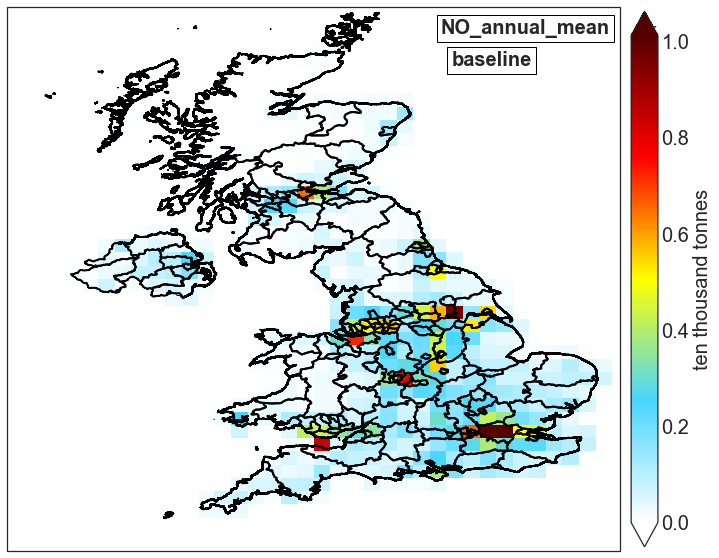

In [90]:
# make the plot of NOx as an test example
fig = plt.figure(figsize=[20,10])
ax = plt.axes(projection=ccrs.PlateCarree())
box = [-9.375,3.75,49.25,59.5] 
ax.set_extent(box)
ax.add_geometries(UK_boundary.geometry, crs=ccrs.PlateCarree(),edgecolor='black',facecolor='none', zorder=1)
ax.add_geometries(UK_city.geometry, crs=ccrs.PlateCarree(),edgecolor='black',facecolor='none',linewidth=2, zorder=1)
NOx_annual_sum.plot(ax=ax,cmap=WhGrYlRd,zorder=0)
ax.set(xlim=(-9.375,2.188))
# and set your colorbar
plt.delaxes(fig.axes[1])
PCM=ax.get_children()[2]
# bounds = np.arange(0,1.25,0.25)
colorbar = plt.colorbar(PCM,ax=ax,label='ten thousand tonnes',orientation='vertical',fraction=0.03,shrink=1,pad=0.012,extend = 'both')
colorbar.ax.tick_params(labelsize=20) 
colorbar.ax.yaxis.label.set_size(20)
ax.text(-1.2,59,'NO_annual_mean',fontsize=20,weight='bold',bbox=dict(facecolor='white', edgecolor='black'))
ax.text(-1,58.4,'baseline',fontsize=20,weight='bold',bbox=dict(facecolor='white', edgecolor='black'))
fig.savefig('D:/Jupyter code/PM output/NO.png', dpi=100, bbox_inches='tight')